# Writing a simple NN
> What is underneath the Neural Networks?

- toc: false 
- badges: true
- comments: true
- categories: [jupyter, posts]
- image: images/nn/relu.png

#hide
## Unknown 
1. Why in gods name doe shuffle=true not work?

## Goal

Understand the workings of an NN(heavily modified/reproduced from [fastbook notbook](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb))

## Concrete Problem and Plan

Recognize 3's and 7's from mnist dataset using the following methods:
- Start with a baseline 
- Write a Linear NN 
- Write a Linear NN using pytorch functions (nn)
- Write a Linear NN using fastai functions
- Write a non-linear NN 
- Write a non-linear NN using pytorch
- Write a non-linear NN using fastai
- Write a (DEEPER 18 layer) non-linear NN using fastai
- compare all answers for epochs, lr and accuracy

## Results upfront

| Method| Epochs | Accuracy| Comment|
|:-------|--------|:---------||
|Baseline| NA| 96.6%||
|Own Linear NN| 20 | 96.5%| Uses slightly different initial values than the rest|
|Linear NN with own SGD | 20 | 98%|  |
|Linear NN with SGD| 20 | 98%||
|Linear NN with fastai| 20 | 98%||
|Own Non-Linear NN |20|98%||
| CNN 18 layer | 1 |99.7%||


## Gathering the Tensors

In [1]:
#hide
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
#hide
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
#hide
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [6]:
#hide
threes_tr = (path/'train'/'3').ls().sorted()
sevens_tr = (path/'train'/'7').ls().sorted()
threes_vd = (path/'valid'/'3').ls().sorted()
sevens_vd = (path/'valid'/'7').ls().sorted()
threes_tr

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

Stack tensors with list comprehension

In [7]:
def stack_tensors(paths):
    lcomp_tensors = [tensor(Image.open(o)) for o in paths]
    print (len(lcomp_tensors))
    return torch.stack(lcomp_tensors).float()/255

In [8]:
stacked_threes_tr = stack_tensors(threes_tr)
stacked_threes_vd = stack_tensors(threes_vd)
stacked_sevens_tr = stack_tensors(sevens_tr)
stacked_sevens_vd = stack_tensors(sevens_vd)

stacked_threes_tr.shape

6131
1010
6265
1028


torch.Size([6131, 28, 28])

--------------------------

## Baseline

- Get mean of `3` and `7` tensors per pixel across all images
- check for each picture if the dstance (l1_norm or l2_norm) is closer to `3` or `7`.

Mean of stacked tensors

(<AxesSubplot:>, <AxesSubplot:>)

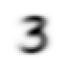

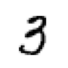

In [9]:
mean_3_2d = stacked_threes_tr.mean((0))
mean_7_2d = stacked_sevens_tr.mean((0))
show_image(mean_3_2d), show_image(stacked_threes_tr[10])

Distance measurement

In [10]:
def l1_norm(a,b): return (a-b).abs().mean((-1,-2))
def l2_norm(a,b): return ((a-b)**2).mean((-1,-2)).sqrt()
# F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt() #pytorch functions

Is a tensor a `3` or `7`?

In [11]:
def is_3(stacked_tensor,mean_3,mean_7): 
    return l2_norm(stacked_tensor, mean_3)<l2_norm(stacked_tensor,mean_7)

Checking the accuracy

In [12]:
accuracy_3s_1 = is_3(stacked_threes_vd,mean_3_2d,mean_7_2d).float().mean()
accuracy_3s_2 = 1-is_3(stacked_sevens_vd,mean_3_2d,mean_7_2d).float().mean()

print("Accuracy of prediction is: ",(accuracy_3s_1+accuracy_3s_2)/2)
## no need to do 7 separately

Accuracy of prediction is:  tensor(0.9661)


**Result**: 97% Accuracy.

-------------------------------

## Write your own Linear NN

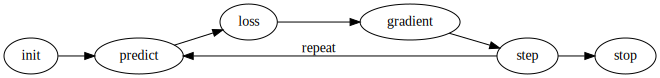

In [13]:
#hide_input
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

**Steps**

1. initialize parameters (`w,b`)
2. Predicit with training vectors (`X@w + b`)
3. Calculate the loss (something that varies with tiny variation of parameters)
4. Calculate the gradient at parameter values (`params.grad`)
5. Make a step based on the gradient (`w -= gradient(w) * lr`)
6. Repeat n times!
7. Calculate Validation accuracy (No. of predictions matching Targets)

In [14]:
#hide
## Concatenate the 7s and 3s
train_x=torch.cat((stacked_threes_tr,stacked_sevens_tr),0).view(-1,28*28)
train_y=tensor(([1]*len(stacked_threes_tr)+[0]*len(stacked_sevens_tr))).unsqueeze(1)
valid_x=torch.cat((stacked_threes_vd,stacked_sevens_vd),0).view(-1,28*28)
valid_y=tensor(([1]*len(stacked_threes_vd)+[0]*len(stacked_sevens_vd))).unsqueeze(1)

train_x.shape,stacked_threes_tr.shape,stacked_sevens_tr.shape,train_y.shape,valid_x.shape,stacked_threes_vd.shape,stacked_sevens_vd.shape

(torch.Size([12396, 784]),
 torch.Size([6131, 28, 28]),
 torch.Size([6265, 28, 28]),
 torch.Size([12396, 1]),
 torch.Size([2038, 784]),
 torch.Size([1010, 28, 28]),
 torch.Size([1028, 28, 28]))

Squeeze into tuple

In [15]:
dset= list(zip(train_x,train_y))
valid_dset = list(zip(valid_x,valid_y))
x,y = dset[0]

x.shape,y,len(dset),type(dset[0])

(torch.Size([784]), tensor([1]), 12396, tuple)

In [16]:
#hide
train_y.shape

torch.Size([12396, 1])

Using Data Loaders to load into batches

In [17]:
dl = DataLoader(dset,batch_size=256,shuffle=False)
dl_vd = DataLoader(valid_dset,batch_size=256,shuffle=False) 
# Not sure why True Shuffle is not working even on the validation set. Somehow it gets shuffled wrong

xb,yb = first(dl_vd)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [18]:
#hide
type(dl_vd)

fastai.data.load.DataLoader

Step 1

In [19]:
def init_params() :
    w = torch.randn(28*28).requires_grad_()
    b = torch.randn(1).requires_grad_()
    return (w,b)

In [20]:
#hide
## step 1 hijacked
def init_params() :
    linear2 = nn.Linear(28*28,1)
    wc,bc = linear2.parameters()
    wc.shape,bc.shape
    w = wc.view(28*28).detach().clone().requires_grad_()
    b = bc.detach().clone().requires_grad_()
    print(w.shape,b.shape,b) 
    return (w,b)

In [21]:
#hide
w,b = init_params()


torch.Size([784]) torch.Size([1]) tensor([0.0187], requires_grad=True)


In [22]:
#hide
lr=1
torch.manual_seed(1)
## check what happen if you use other lrs
w,b = init_params()
params=w,b


torch.Size([784]) torch.Size([1]) tensor([-0.0274], requires_grad=True)


Step 2

In [23]:
def linear1(tens):
    return tens@w+b   

Step 3

In [24]:
def mnist_loss(prediction,target):
    prediction = prediction.sigmoid()
    return torch.where(target==1,1-prediction,prediction).mean()
## Check what happenes if you use sum (guess: nothing different)

In [25]:
#hide
mnist_loss(linear1(xb),yb)

tensor(0.5208, grad_fn=<MeanBackward0>)

Step 4

In [26]:
def calc_grad(xb,yb,model):
    pred = model(xb)
    loss = mnist_loss(pred,yb)
    loss.backward()

Step 1-5

In [27]:
def train_epoch(dl,model,params):
    for xb,yb in dl:
        calc_grad(xb,yb,model)
        for p in params:
            # print(b,params[1])
            p.data-= p.grad*lr
            # print(b,params[1])
            p.grad.zero_()
            ## p.data is needed otherwise get leaf-variable error

In [28]:
#hide
train_epoch(dl,linear1,params)
w.grad.mean(),b


(tensor(0.), tensor([0.1827], requires_grad=True))

In [29]:
#hide
x,y = first(dl)
x.shape,y.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

Step 7

In [30]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [31]:
def validate_epoch(dl,model):
    accs = [batch_accuracy(model(xb),yb) for xb,yb in dl]
    return round(torch.stack(accs).mean().item(), 4)

    

In [32]:
#hide
validate_epoch(dl_vd,linear1)

0.4932

Setting parameters

In [33]:
lr=1
torch.manual_seed(0)
w,b = init_params()
params=w,b

torch.Size([784]) torch.Size([1]) tensor([-0.0198], requires_grad=True)


Training

In [34]:
for i in range(20):
    train_epoch(dl, linear1, params)
    print(validate_epoch(dl_vd, linear1), end=' ')

0.4932 0.8298 0.8219 0.8996 0.9232 0.9344 0.9432 0.9489 0.9537 0.9551 0.957 0.9585 0.9614 0.9619 0.9633 0.9643 0.9648 0.9648 0.9657 0.9657 

**Result**: 96 percent with 20 epochs

----------------------

## Doing it with own BASIC OPTIM

In [35]:
#hide
linear2 = nn.Linear(28*28,1)
linear2

Linear(in_features=784, out_features=1, bias=True)

In [36]:
#hide
w,b = linear2.parameters()
w.shape, b.shape, b

(torch.Size([1, 784]),
 torch.Size([1]),
 Parameter containing:
 tensor([-0.0229], requires_grad=True))

In [37]:
#hide
b

Parameter containing:
tensor([-0.0229], requires_grad=True)

SGD

In [38]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr
        
    def step(self):
        for p in self.params: p.data -= p.grad *self.lr
            
    def zero_grad(self):
        for p in self.params: p.grad = None # p.grad.zero_() also OK.

In [39]:
#hide
opt = BasicOptim(linear2.parameters(),lr)

In [40]:
def train_epoch(dl,model):
    for xb,yb in dl:
        calc_grad(xb,yb,model)
        opt.step()
        opt.zero_grad()
    

In [41]:
def train_model(dl,model, no_epochs):
    for i in range(no_epochs):
        train_epoch(dl,model)
        print(validate_epoch(dl_vd,linear2), end=' ')
    

Setting parameters

In [42]:
lr=1
torch.manual_seed(0)
linear2 = nn.Linear(28*28,1)
opt = BasicOptim(linear2.parameters(),lr)

In [43]:
train_model(dl, linear2,20)

0.4932 0.8843 0.814 0.9087 0.9336 0.9463 0.9555 0.9614 0.9663 0.9673 0.9697 0.9712 0.9741 0.9751 0.9761 0.977 0.9775 0.9775 0.9785 0.9785 

**Result**: 98% with 20 epochs

----------------------

## Linear NN with built in SGD

In [44]:
#hide
lr=1
torch.manual_seed(0)
linear2 = nn.Linear(28*28,1)
opt = SGD(linear2.parameters(), lr)

In [45]:
#hide
type(SGD)

function

In [46]:
def train_model(dl,model, no_epochs):
    for i in range(no_epochs):
        train_epoch(dl,model)
        print(validate_epoch(dl_vd,linear2), end=' ')
    

Setting parameters

In [47]:
lr=1
torch.manual_seed(0)
linear2 = nn.Linear(28*28,1)
opt = BasicOptim(linear2.parameters(),lr)

In [48]:
train_model(dl, linear2,20)

0.4932 0.8843 0.814 0.9087 0.9336 0.9463 0.9555 0.9614 0.9663 0.9673 0.9697 0.9712 0.9741 0.9751 0.9761 0.977 0.9775 0.9775 0.9785 0.9785 

**Result**: 98% with 20 epochs

----------------------

## Linear NN with fastai

Everything in 3 lines

In [49]:
dls = DataLoaders(dl,dl_vd)

learn = Learner(dls, nn.Linear(28*28,1),opt_func=SGD, loss_func=mnist_loss,metrics=batch_accuracy)

learn.fit(10,lr=lr) ## part which is a for loop of training and validating

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637098,0.503163,0.495584,00:00
1,0.439934,0.228752,0.797350,00:00
2,0.164458,0.165872,0.850343,00:00
3,0.073856,0.101805,0.916094,00:00
4,0.040425,0.075480,0.933759,00:00
5,0.027307,0.060971,0.948479,00:00
6,0.021858,0.051846,0.957311,00:00
7,0.019390,0.045741,0.962709,00:00
8,0.018109,0.041433,0.965653,00:00
9,0.017324,0.038244,0.967125,00:00


**Result**: 97% with 10 epochs

----------------------

## Adding a nonlinearity

Non-linear NN with RELU (Rectified Linear Unit)

In [50]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [51]:
#hide
res = torch.arange(-100,100,10)

res.max(tensor(0))

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

Initializing parameters

In [52]:
def init_params2(size): return torch.randn(size).requires_grad_()

In [53]:
w1 = init_params2((28*28,30))
b1 = init_params2(1)
w2 = init_params2(30)
b2 = init_params2(1)

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastbook/__init__.py:55: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


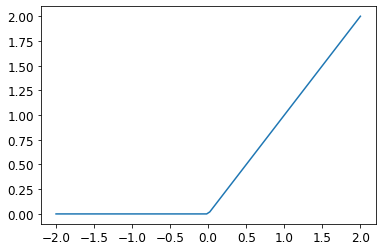

In [54]:
#hide_input
plot_function(F.relu)

Non-linear NN with pytorch

In [55]:
simple_net2 = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [56]:
learn2 = Learner(dls, simple_net2,opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

learn2.fit(20,0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.333909,0.405487,0.504416,00:00
1,0.153576,0.240681,0.790481,00:00
2,0.083833,0.117808,0.913150,00:00
3,0.054202,0.078306,0.941609,00:00
4,0.040586,0.060718,0.957311,00:00
5,0.033723,0.050975,0.964181,00:00
6,0.029842,0.044882,0.966143,00:00
7,0.027354,0.040743,0.968597,00:00
8,0.025581,0.037743,0.969578,00:00
9,0.024215,0.035456,0.970069,00:00


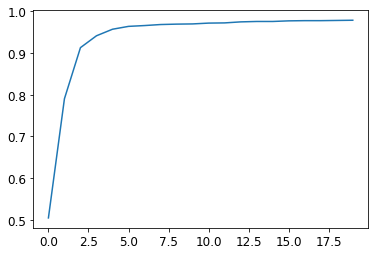

In [57]:
#hide
plt.plot(L(learn2.recorder.values).itemgot(2));

----------------------

## CNN with 18 layers with fastai

18 layer model #resnet18

In [58]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.068580,0.012664,0.995584,00:08


**Result**: 99.7% with 1 epoch

##  Results

| Method| Epochs | Accuracy| comment|
|-------|--------|---------||
|Baseline| NA| 96.6%||
|Own Linear NN| 20 | 96.5%| Uses different initial values than the rest|
|Linear NN with own SGD | 20 | 98%|  |
|Linear NN with SGD| 20 | 98%||
|Linear NN with fastai| 20 | 98%||
|Own Non-Linear NN |20|98%||
| CNN 18 layer | 1 |99.7%||
